# Исследование поведения пользователей мобильного приложения по продаже продуктов питания на основании результатов, полученных после проведения A/A/B-эксперимента

Данное исследование проводится с целью узнать, как ведут себя пользователи мобильного приложения по продаже продуктов питания. Для ответа на поставленный вопрос необходимо провести A/A/B-эксперимент. Для проведения экперемента пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. На основании результатов эксперемента будет сделан вывод о целесообразности изменения интерфейса(а именно, шрифта) мобильного приложения.  

## Оглавление

### [Описание данных](#step1)
### [Изучение общей информации](#step2)
### [Подготовка данных](#step3)
### [Изучение и проверка данных](#step4)
#### [Сколько всего событий в логе?](#step5)
#### [Сколько всего пользователей в логе?](#step6)
#### [Сколько в среднем событий приходится на пользователя?](#step7)
#### [Данными за какой период вы располагаете?](#step8)
#### [Много ли событий и пользователей вы потеряли, отбросив старые данные?](#step9)
#### [Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп](#step10)
### [Изучение воронки событий](#step11)
#### [Посмотрите, какие события есть в логах, как часто они встречаются](#step12)
#### [Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие](#step13)
#### [Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки](#step14)
#### [По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки](#step15)
#### [На каком шаге теряете больше всего пользователей?](#step16)
#### [Какая доля пользователей доходит от первого события до оплаты?](#step17)
### [Изучение результатов эксперимента](#step18)
#### [Сравнение группы 246 и группы 247. При α=0.05 ](#step19)
#### [Сравнение группы 246 и группы 248. При α=0.05  ](#step20)
#### [Сравнение группы 247 и группы 248. При α=0.05 ](#step21)
#### [Сравнение группы 246+247 и группы 248. При α=0.05 ](#step22)
#### [Множественная проверка гипотез Бонферрони. При α=0.05 ](#step23)
#### [Сравнение группы 246 и группы 247. При α=0.01](#step24)
#### [Сравнение группы 246 и группы 248. При α=0.01](#step25)
#### [Сравнение группы 247 и группы 248. При α=0.01](#step26)
#### [Сравнение группы 246+247 и группы 248. При α=0.01](#step27)
#### [Множественная проверка гипотез Бонферрони. При α=0.01](#step28)
### [Вывод](#step29)

## Описание данных <a name="step1"></a>

Каждая запись в логе — это действие пользователя, или событие.
* EventName — название события;
* DeviceIDHash — уникальный идентификатор пользователя;
* EventTimestamp — время события;
* ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Изучение общей информации  <a name="step2"></a>

In [25]:
#Импортируем необходимые в дальнейшем библиотеки
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import requests
import os 

import scipy.stats as stats
from scipy import stats as st
from pandas.io.json import json_normalize
from pprint import pprint
import json


import math
import numpy as np
import re

In [26]:
#Загружаем датасет
df = pd.read_csv('/datasets/logs_exp.csv', delimiter='\t')


In [27]:
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


## Подготовка данных <a name="step3"></a>

Поменяем название столбцов, приведем содержимое к строковым буквам

In [29]:
df = df.rename(columns={'EventName': 'event_name', 'DeviceIDHash': 'user_id', 'EventTimestamp': 'date_and_time', 'ExpId': 'experiment_number'})

In [30]:
df['event_name'] = df['event_name'].str.lower()

Переведем время в правильный формат

In [31]:
df['date_and_time'] = df['date_and_time'].astype('datetime64[s]')

In [32]:
df.head()

,event_name,user_id,date_and_time,experiment_number
0,mainscreenappear,4575588528974610257,2019-07-25 04:43:36,246
1,mainscreenappear,7416695313311560658,2019-07-25 11:11:42,246
2,paymentscreensuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,cartscreenappear,3518123091307005509,2019-07-25 11:28:47,248
4,paymentscreensuccessful,6217807653094995999,2019-07-25 11:48:42,248


In [33]:
df.isnull().sum()

event_name           0
user_id              0
date_and_time        0
experiment_number    0
dtype: int64

In [34]:
df.duplicated().sum()

413

Предположим, что дубликаты - ошибка ввода данных, удаляем их

In [35]:
df = df.drop_duplicates().reset_index(drop=True)

In [36]:
df.duplicated().sum()

0

Добавим отдельный столбец с датами

In [37]:
df['date'] = df['date_and_time'].astype('datetime64[D]')

In [38]:
df.head()

,event_name,user_id,date_and_time,experiment_number,date
0,mainscreenappear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,mainscreenappear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,paymentscreensuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,cartscreenappear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,paymentscreensuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


Данные подчищены, приведены к "правильным" форматам, столбец с датами добавлен, дубликатов нет, пропусков нет. Можно приступать к изучению и проверке данных

## Изучение и проверка данных <a name="step4"></a>

### Сколько всего событий в логе? <a name="step5"></a>

In [39]:
print('Уникальных событий в логе : %d.' % df['event_name'].nunique())

Уникальных событий в логе : 5.


### Сколько всего пользователей в логе? <a name="step6"></a>

In [40]:
print('Уникальных пользователей в логе : %d.' % df['user_id'].nunique())

Уникальных пользователей в логе : 7551.


### Сколько в среднем событий приходится на пользователя?<a name="step7"></a>

In [41]:
print('На пользователя в среднем приходится %d события' % (df.shape[0] / df['user_id'].nunique()))

На пользователя в среднем приходится 32 события


### Данными за какой период вы располагаете? <a name="step8"></a>

* Найдите максимальную и минимальную дату. 
* Постройте гистограмму по дате и времени. 
* Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». 
* Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?

In [42]:
first_date = df['date'].min()
first_date

Timestamp('2019-07-25 00:00:00')

In [43]:
last_date = df['date'].max()
last_date

Timestamp('2019-08-07 00:00:00')

In [44]:
print('Разница между событиями : %s.' % (last_date - first_date))

Разница между событиями : 13 days 00:00:00.


In [45]:
events_per_day = df.groupby('date')['event_name'].count().reset_index()
events_per_day

,date,event_name
0,2019-07-25,9
1,2019-07-26,31
2,2019-07-27,55
3,2019-07-28,105
4,2019-07-29,184
5,2019-07-30,412
6,2019-07-31,2030
7,2019-08-01,36141
8,2019-08-02,35554
9,2019-08-03,33282


In [46]:
# Код ревьюера
events_per_day['date'] = events_per_day['date'].dt.date

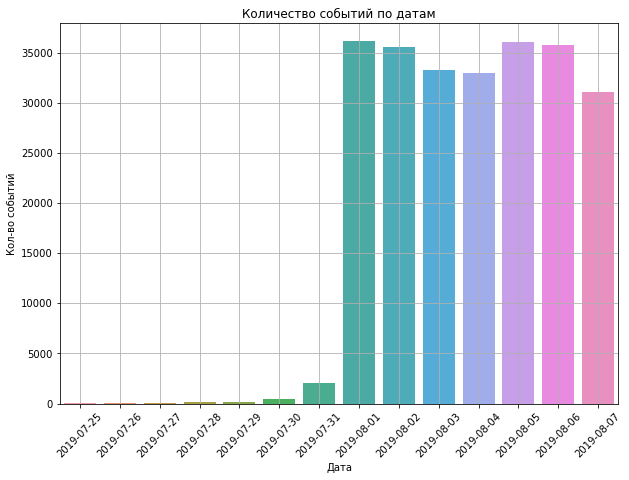

In [47]:
plt.figure(figsize=(10, 7))
ax = sns.barplot(x='date', y='event_name', data=events_per_day)
plt.xticks(rotation=45)
plt.title('Количество событий по датам')
plt.ylabel('Кол-во событий')
plt.xlabel('Дата')
plt.grid(True)
plt.show;

Оставим только данные за неделю с 1 по 8е августа включительно. Остальное отбрасываем

In [48]:
df_filter = df.loc[df['date'] >= '2019-08-01']
df_filter.head()

,event_name,user_id,date_and_time,experiment_number,date
2826,tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2827,mainscreenappear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2828,mainscreenappear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2829,offersscreenappear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2830,mainscreenappear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01


### Много ли событий и пользователей вы потеряли, отбросив старые данные?<a name="step9"></a>

In [49]:
print('До фильрации : Уникальных событий в логе : %d.' % df_filter['event_name'].nunique())
print('После фильтрации : Уникальных событий в логе : %d.' % df_filter['event_name'].nunique())

До фильрации : Уникальных событий в логе : 5.
После фильтрации : Уникальных событий в логе : 5.


In [50]:
delited_user_id = 1- (df_filter['user_id'].nunique() / df['user_id'].nunique())
delited_user_id

0.0022513574361011646

In [51]:
print('До фильтрации : Уникальных пользователей в логе : %d.' % df['user_id'].nunique())
print('После фильтрации : Уникальных пользователей в логе : %d.' % df_filter['user_id'].nunique())
print('После фильтрации удалено значений : {:,.2%}'.format(delited_user_id))

До фильтрации : Уникальных пользователей в логе : 7551.
После фильтрации : Уникальных пользователей в логе : 7534.
После фильтрации удалено значений : 0.23%


In [52]:
delited = 1- ((df_filter.shape[0] / df_filter['user_id'].nunique()) / (df.shape[0] / df['user_id'].nunique()))
delited

0.009365333584725244

In [53]:
print('До фильтрации : На пользователя в среднем приходится %d событий' % (df.shape[0] / df['user_id'].nunique()))
print('После фильтрации : На пользователя в среднем приходится %d событий' % (df_filter.shape[0] / df_filter['user_id'].nunique()))
print('После фильтрации удалено значений : {:,.2%}'.format(delited))

До фильтрации : На пользователя в среднем приходится 32 событий
После фильтрации : На пользователя в среднем приходится 31 событий
После фильтрации удалено значений : 0.94%


Данные до и после фильтрации различаются, но незначительно. Можно сказать, что, на самом деле, мы располагаем данными за неделю

### Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп<a name="step10"></a>

In [54]:
df_filter['experiment_number'].unique()

array([246, 247, 248])

In [55]:
test =  df_filter.groupby('user_id')['experiment_number'].nunique().reset_index()
test

,user_id,experiment_number
0,6888746892508752,1
1,6909561520679493,1
2,6922444491712477,1
3,7435777799948366,1
4,7702139951469979,1
...,...,...
7529,9217594193087726423,1
7530,9219463515465815368,1
7531,9220879493065341500,1
7532,9221926045299980007,1


In [56]:
test[test['experiment_number'] > 1]

,user_id,experiment_number


Все четко. Ни одна группа не потерялась

## Изучение воронки событий<a name="step11"></a>

### Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте <a name="step12"></a>

In [57]:
df_filter['event_name'].unique()

array(['tutorial', 'mainscreenappear', 'offersscreenappear',
       'cartscreenappear', 'paymentscreensuccessful'], dtype=object)

In [58]:
event_frequency = df_filter.groupby('event_name')['user_id'].count().reset_index().sort_values(by = 'user_id', ascending = False)
event_frequency

,event_name,user_id
1,mainscreenappear,117328
2,offersscreenappear,46333
0,cartscreenappear,42303
3,paymentscreensuccessful,33918
4,tutorial,1005


Самое частое событие - Главный экран

### Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие. <a name="step13"></a>

In [59]:
df_funnel = df_filter.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).reset_index()

In [60]:
df_funnel = df_funnel.rename(columns={'user_id': 'unique_users'})

In [61]:
df_funnel['percent'] = ((df_funnel['unique_users'] / df_filter['user_id'].nunique()) * 100).round(2)
df_funnel

,event_name,unique_users,percent
0,mainscreenappear,7419,98.47
1,offersscreenappear,4593,60.96
2,cartscreenappear,3734,49.56
3,paymentscreensuccessful,3539,46.97
4,tutorial,840,11.15


### Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки. <a name="step14"></a>

Да, они выстраиваются в последовательную цепочку, и вглядит она так. Из общей последовательности выбивается этап tutorial. Tutorial — низкочастотное событие и мало уников с ним столкнулось, но по логике оно должно идти до главного экрана. На основании этого мы можем не учитывать его при расчете воронки
* Инструкция 
* Главный экран
* Приложение
* Корзина
* Оплата

### По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B. <a name="step15"></a>

In [62]:
df_funnel.drop([4], inplace=True)

In [63]:
from plotly import graph_objects as go

fig = go.Figure(go.Funnel(
    y = df_funnel['event_name'],
    x = df_funnel['unique_users']))

fig.show()

ModuleNotFoundError: No module named 'plotly'

In [ ]:
from plotly import graph_objects as go

fig = go.Figure(go.Funnel(
    y = df_funnel['event_name'],
    x = df_funnel['percent']))

fig.show()

### На каком шаге теряете больше всего пользователей?<a name="step16"></a>

Больше всего пользователей теряется на этапе перехода с главного экрана на следующий шаг

### Какая доля пользователей доходит от первого события до оплаты?<a name="step17"></a>

47.7% доходят до оплаты, почти половина пльзователей

## Изучение результатов эксперимента<a name="step18"></a>

In [ ]:
df_filter.head()

Посмотрим, сколько всего пользователей в каждой группе эксперимента

In [ ]:
people_per_group = df_filter.groupby('experiment_number')['user_id'].nunique().reset_index()
people_per_group

Построим сводную таблицу пользователей по всем группам, совершившим каждое действие

In [ ]:
pivot = df_filter.pivot_table(index = 'experiment_number', columns = 'event_name', values = 'user_id', aggfunc = 'nunique')
pivot = pivot.merge(people_per_group, on = 'experiment_number').rename(columns={'user_id': 'total_users_in_group'})
pivot.loc[3] = ['246+247', 2504, 4926, 3062, 2358, 561, 4997]
pivot

Проверим гипотезу о равности долей пользователей, совершивших каждое событие, в группах 246 и 247, далее каждую из этих групп сравним с группой 248, а затем сумму людей групп 246 и 247 на каждом шаге сравним с количеством людей на каждом шаге группы 248

Для сравнения используем Z-тест

Для каждого из событий будем сравнивать отдельно

* Нулевая гипотеза: Доли в группах равны <br>
* Альтернативная гипотеза: Доли в группах НЕ равны

In [ ]:
import math as mth
def ztest (x, y, x1, y1):

    alpha = 0.05 # критический уровень статистической значимости

    successes = np.array([x, y])
    trials = np.array([x1, y1])

# пропорция успехов в группе 246:
    p1 = successes[0]/trials[0]

# пропорция успехов в группе 247:
    p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
    difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

# считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2
    

    print('p-значение: {p_value:.2f}'.format(p_value=p_value))

    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными") 

In [ ]:
#Проще всего пройтись циклом

In [ ]:
for i in range(len(pivot)-1) : 
    for j in range(1, 6):
        print('Проверка для  {} и {}, событие: {}'.format(pivot.iloc[i, 0], pivot.iloc[i+1, 0], pivot.columns[j]))
        ztest (pivot.iloc[i, j], pivot.iloc[i+1, j], pivot.iloc[i, 6], pivot.iloc[i+1, 6])
        print('------------------------------------------')
for p in range(1, 6):
    print('Проверка для  {} и {}, событие: {}'.format(pivot.iloc[0, 0], pivot.iloc[2, 0], pivot.columns[p]))
    ztest (pivot.iloc[0, p], pivot.iloc[2, p], pivot.iloc[0, 6], pivot.iloc[2, 6])
    print('------------------------------------------')    
    

По результатам проведенных нами тестов можно смело утверждать, что различий между долями в группах нет. Это касается и контрольных групп, и эксперементальной

#### Множественная проверка гипотез Бонферрони <a name="step23"></a>

In [ ]:
pvalues_list = [0.23, 0.76, 0.25, 0.11, 0.94]

In [ ]:
pvalues_list1 = [0.08, 0.29, 0.21, 0.21, 0.83]

In [ ]:
pvalues_list2 = [0.58, 0.46, 0.92, 0.74, 0.77]

In [ ]:
pvalues_list3 = [0.18, 0.29, 0.43, 0.60, 0.76]

При определении уровня статистической значимости необходимо воспользоваться поправкой на множественную проверку гипотез Бонферрони <a name="step23"></a>

Что показывает нам проверка:
* первое значение — это была ли отвергнута нулевая гипотеза (True — нулевая ложна, различия есть, False — нулевая верна, различий нет), сравнивают альфу с поправкой;
* второе значение — скорректированные p-value для теста с множественными сравнениями;
* третье значение — альфа с поправкой Шидака;
* четвертое значение — альфа с поправкой Бонферрони.

#### Проверка для  246 и 247. При α=0.05

In [ ]:
from statsmodels.stats.multitest import multipletests
# pvals — список с тестовыми p-value
multipletests(pvals=pvalues_list, alpha=.05, method='bonferroni')

#### Проверка для  246 и 248. При α=0.05

In [ ]:
multipletests(pvals=pvalues_list1, alpha=.05, method='bonferroni')

#### Проверка для  247 и 248. При α=0.05

In [ ]:
multipletests(pvals=pvalues_list2, alpha=.05, method='bonferroni')

#### Проверка для  246+247 и 248. При α=0.05

In [ ]:
multipletests(pvals=pvalues_list3, alpha=.05, method='bonferroni')

Выше мы сделали 20 проверок статистических гипотез(4 AA теста и 16 AB тестов). При проверке мы брали уровень статистической значимости равным 5%.<br> При множественной проверке гипотез Бонферрони рекомендованное значение статистической значимости 1%. Проверим, изменятся ли результаты при α=0.01

In [ ]:
import math as mth
def ztest (x, y, x1, y1):

    alpha = 0.01 # критический уровень статистической значимости

    successes = np.array([x, y])
    trials = np.array([x1, y1])

# пропорция успехов в группе 246:
    p1 = successes[0]/trials[0]

# пропорция успехов в группе 247:
    p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
    difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

# считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2
    

    print('p-значение: {p_value:.2f}'.format(p_value=p_value))

    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными") 

In [ ]:
for i in range(len(pivot)-1) : 
    for j in range(1, 6):
        print('Проверка для  {} и {}, событие: {}'.format(pivot.iloc[i, 0], pivot.iloc[i+1, 0], pivot.columns[j]))
        ztest (pivot.iloc[i, j], pivot.iloc[i+1, j], pivot.iloc[i, 6], pivot.iloc[i+1, 6])
        print('------------------------------------------')
for p in range(1, 6):
    print('Проверка для  {} и {}, событие: {}'.format(pivot.iloc[0, 0], pivot.iloc[2, 0], pivot.columns[p]))
    ztest (pivot.iloc[0, p], pivot.iloc[2, p], pivot.iloc[0, 6], pivot.iloc[2, 6])
    print('------------------------------------------')   

#### Множественная проверка гипотез Бонферрони  <a name="step28"></a>

#### Проверка для  246 и 247. При α=0.01

In [ ]:
multipletests(pvals=pvalues_list, alpha=.01, method='bonferroni')

#### Проверка для  246 и 248. При α=0.01

In [ ]:
multipletests(pvals=pvalues_list1, alpha=.01, method='bonferroni')

#### Проверка для  247 и 248. При α=0.01

In [ ]:
multipletests(pvals=pvalues_list2, alpha=.01, method='bonferroni')

#### Проверка для  246+247 и 248. При α=0.01

In [ ]:
multipletests(pvals=pvalues_list3, alpha=.01, method='bonferroni')

Несмотря на то,что при уровне значимости 1% каждый десятый раз можно получать ложный результат, результаты эксперементов не изменились. <br> К тому же, значение α=0.05 рекомендовано для небольших выборок (когда высока вероятность ошибки второго рода). Если объемы выборок n≥100, то порог отклонения целесообразно снизить до α=0.01. Исходя из этого, я бы снизила порог до 1%

## Вывод <a name="step29"></a>

По итогам нашего A/A/B-теста различий между контрольными группами 246 и 247, которые пользовались приложением со старфм шрифтом, и группой 248, на которой тестировали новый шрифт, не наблюдалось. Не уверена, целесообразно ли это вообще, менять шрифт. С другой стороны, очень многие пользователи "отваливаются" на этапе главного экрана. Это может быть индикатором того, что интерфейс приложения им не нравится, и они уходят. Значит, что то надо с этим делать, но изменение шрифта ни к чему, увы, не привело.